# Machine Learning Foundations - Final Project - Data Cleaning
# Team 23: Citi Bike in New York City
## Fuman Annie Xie and Jiaxuan Alice Ji

[IMPORTANT]Please notice that the raw data we used here and the resulting cleaned dataset (2.5 percent of raw data, about 120 MB) are both uploaded to the following link:
https://drive.google.com/file/d/1YokW0NpfP8K8AAoIkt_ZsUzGJPiIPano/view?usp=sharing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score, mean_squared_error
from matplotlib import pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, Polygon
from pyproj import CRS

%matplotlib inline

# 1 Data Preprocessing
In this section, we have two goals.
1. Merge three datasets(bike trip data, weather data, and location demographic data)
* To merge weather data, we extract the date from bike trip data and merge on date.
* To merge location demographic data, we first identify which community district and borough each station is in with the help of NYC shapefiles. And then we merge demographic information based on the location.
2. Prepare the merged dataset for prediction and classification
* Handle null values
* Deal with categorical variables



## 1.1 Import bike trip data and handle null values
We downloaded data from 2022.03 to 2023.02, which have in total about 32 million samples. So we sampled a porpotion of all the data based on the capacity of our laptops. 

In [2]:
# this cell takes a minute or two
trip2203 = pd.read_csv('data/bikedata/202203.csv', dtype={"start_station_id": str, "end_station_id": str })
trip2204 = pd.read_csv('data/bikedata/202204.csv', dtype={"start_station_id": str, "end_station_id": str })
trip2205 = pd.read_csv('data/bikedata/202205.csv', dtype={"start_station_id": str, "end_station_id": str })
trip2206 = pd.read_csv('data/bikedata/202206.csv', dtype={"start_station_id": str, "end_station_id": str })
trip2207 = pd.read_csv('data/bikedata/202207.csv', dtype={"start_station_id": str, "end_station_id": str })
trip2208 = pd.read_csv('data/bikedata/202208.csv', dtype={"start_station_id": str, "end_station_id": str })
trip2209 = pd.read_csv('data/bikedata/202209.csv', dtype={"start_station_id": str, "end_station_id": str })
trip2210 = pd.read_csv('data/bikedata/202210.csv', dtype={"start_station_id": str, "end_station_id": str })
trip2211 = pd.read_csv('data/bikedata/202211.csv', dtype={"start_station_id": str, "end_station_id": str })
trip2212 = pd.read_csv('data/bikedata/202212.csv', dtype={"start_station_id": str, "end_station_id": str })
trip2301 = pd.read_csv('data/bikedata/202301.csv', dtype={"start_station_id": str, "end_station_id": str })
trip2302 = pd.read_csv('data/bikedata/202302.csv', dtype={"start_station_id": str, "end_station_id": str })

In [3]:
# this cell takes a minute or two
trip2203 = trip2203.sample(frac = 0.05, random_state = 1)
trip2204 = trip2204.sample(frac = 0.05, random_state = 1)
trip2205 = trip2205.sample(frac = 0.05, random_state = 1)
trip2206 = trip2206.sample(frac = 0.05, random_state = 1)
trip2207 = trip2207.sample(frac = 0.05, random_state = 1)
trip2208 = trip2208.sample(frac = 0.05, random_state = 1)
trip2209 = trip2209.sample(frac = 0.05, random_state = 1)
trip2210 = trip2210.sample(frac = 0.05, random_state = 1)
trip2211 = trip2211.sample(frac = 0.05, random_state = 1)
trip2212 = trip2212.sample(frac = 0.05, random_state = 1)
trip2301 = trip2301.sample(frac = 0.05, random_state = 1)
trip2302 = trip2302.sample(frac = 0.05, random_state = 1)

In [4]:
trip2223 = pd.concat([trip2203, trip2204, trip2205, trip2206, trip2207, trip2208, 
                      trip2209, trip2210, trip2211, trip2212, trip2301, trip2302])

In [5]:
trip2223.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600557 entries, 542945 to 1291284
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ride_id             1600557 non-null  object 
 1   rideable_type       1600557 non-null  object 
 2   started_at          1600557 non-null  object 
 3   ended_at            1600557 non-null  object 
 4   start_station_name  1600549 non-null  object 
 5   start_station_id    1600549 non-null  object 
 6   end_station_name    1597039 non-null  object 
 7   end_station_id      1597039 non-null  object 
 8   start_lat           1600557 non-null  float64
 9   start_lng           1600557 non-null  float64
 10  end_lat             1598924 non-null  float64
 11  end_lng             1598924 non-null  float64
 12  member_casual       1600557 non-null  object 
dtypes: float64(4), object(9)
memory usage: 171.0+ MB


In [6]:
trip2223 = trip2223.dropna()

## 1.2 Merge demographic data
Extract all the stations and find out which community district and borough they are in so that we can add location-specific demographics to each station.

In [7]:
len(trip2223.start_station_name.unique())

1835

In [8]:
stations = trip2223[['start_station_id','start_station_name','start_lat','start_lng']].drop_duplicates(subset = ['start_station_name'])
stations.columns = ['station_id', 'station_name','lat','lng']

In [9]:
trip = trip2223.sample(frac = 0.5, random_state = 1)

In [10]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798520 entries, 1070339 to 2226188
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             798520 non-null  object 
 1   rideable_type       798520 non-null  object 
 2   started_at          798520 non-null  object 
 3   ended_at            798520 non-null  object 
 4   start_station_name  798520 non-null  object 
 5   start_station_id    798520 non-null  object 
 6   end_station_name    798520 non-null  object 
 7   end_station_id      798520 non-null  object 
 8   start_lat           798520 non-null  float64
 9   start_lng           798520 non-null  float64
 10  end_lat             798520 non-null  float64
 11  end_lng             798520 non-null  float64
 12  member_casual       798520 non-null  object 
dtypes: float64(4), object(9)
memory usage: 85.3+ MB


In [52]:
boro_map = gpd.read_file('data/boro_shp/boro.shp')
cd_map = gpd.read_file('data/cd_shp/community_districts.shp')
bike_route = gpd.read_file('data/bike_route_shp/bikeroute.shp')

In [13]:
boro_map.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,5.0,Staten Island,1.623621e+09,325917.353702,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,2.0,Bronx,1.187175e+09,463179.772813,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,1.0,Manhattan,6.365208e+08,357564.316391,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
3,3.0,Brooklyn,1.934143e+09,728197.541089,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
4,4.0,Queens,3.041419e+09,888199.731579,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


In [14]:
geometry=[Point(xy) for xy in zip(stations["lng"], stations["lat"])]

In [15]:
crs= CRS('epsg:4326')#{}
stations_map = gpd.GeoDataFrame(stations,crs=crs, geometry=geometry)

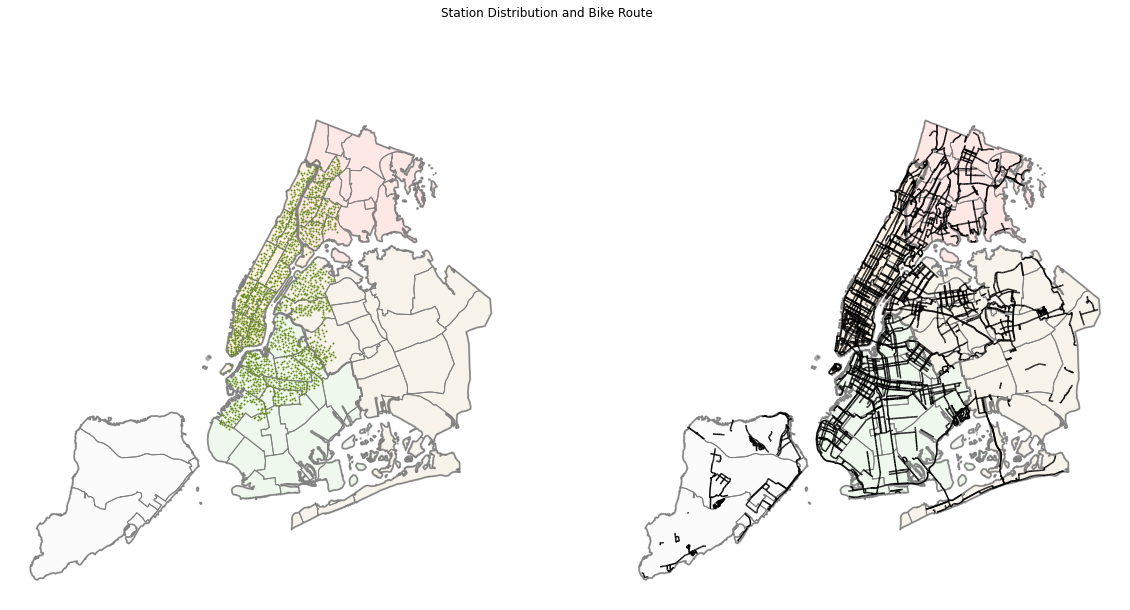

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

boro_map.plot(ax = ax[0], column = 'boro_name', cmap = 'Pastel1', edgecolor = 'black' , linewidth = 2, alpha = 0.3)
cd_map.plot(ax = ax[0], color = 'none', edgecolor = 'grey')
stations_map.plot(ax = ax[0], color='olivedrab', markersize=1)

boro_map.plot(ax = ax[1], column = 'boro_name', cmap = 'Pastel1', edgecolor = 'black' , linewidth = 2, alpha = 0.3)
cd_map.plot(ax = ax[1], color = 'none', edgecolor = 'grey')
bike_route.plot(ax = ax[1], color = 'black')
ax[0].set_axis_off();
ax[1].set_axis_off();
fig.suptitle('Station Distribution and Bike Route', fontsize=12)
plt.show()

In [17]:
stations_map.reset_index(inplace = True, drop = True)

In [18]:
cd_map.head()

,boro_cd,shape_area,shape_leng,geometry
0,308.0,4.560379e+07,38232.886649,"POLYGON ((-73.95829 40.67983, -73.95596 40.679..."
1,101.0,4.168665e+07,69054.447232,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
2,414.0,1.955766e+08,210918.175118,"MULTIPOLYGON (((-73.90972 40.56529, -73.90973 ..."
3,204.0,5.552214e+07,31358.450463,"POLYGON ((-73.90269 40.84458, -73.90271 40.844..."
4,501.0,3.772325e+08,153751.224394,"MULTIPOLYGON (((-74.15946 40.64145, -74.15975 ..."


In [19]:
# check which community district and borough each station is in 
# judging by whether the coordinate of the station is within the polygon of a community district/
stations_map['cd'] = ''
stations_map['boro'] = ''
for idx, station_info in stations_map.iterrows():
    point = station_info.geometry
    for num, row in cd_map.iterrows():
        if row.geometry.contains(point) is True: 
            stations_map.loc[idx, 'cd'] = row.boro_cd
            break
    for num, row in boro_map.iterrows():
        if row.geometry.contains(point) is True: 
            stations_map.loc[idx, 'boro'] = row.boro_name
            break

In [20]:
stations_map[stations_map.cd == '']

,station_id,station_name,lat,lng,geometry,cd,boro


In [21]:
stations_map.head()

,station_id,station_name,lat,lng,geometry,cd,boro
0,4322.06,Bergen St & 4 Ave,40.682564,-73.979898,POINT (-73.97990 40.68256),302.0,Brooklyn
1,4066.15,Bedford Ave & Bergen St,40.676368,-73.952918,POINT (-73.95292 40.67637),308.0,Brooklyn
2,6224.05,W 20 St & 8 Ave,40.743453,-74.000040,POINT (-74.00004 40.74345),104.0,Manhattan
3,6122.09,2 Ave & E 29 St,40.741724,-73.978093,POINT (-73.97809 40.74172),106.0,Manhattan
4,4428.02,Cumberland St & Lafayette Ave,40.687534,-73.972652,POINT (-73.97265 40.68753),302.0,Brooklyn


Now that we know which borough and community district each station is in, we can merge borough-level and community-district-level demographic information into the dataset.

In [22]:
boro_info = pd.read_excel('data/boro_demographics/boro_info_combined.xlsx')
boro_info.head()

,Borough,car_free_commute,mean_travel_time_to_work,serious_crime_rate,median_household_income,population_density,poverty_rate
0,Brooklyn,0.749,43.8,10.8,70340,36.9,0.177
1,The Bronx,0.711,45.9,14.0,43540,33.7,0.264
2,Manhattan,0.884,31.7,17.1,98410,71.9,0.140
3,Queens,0.589,44.2,9.3,77440,20.7,0.108
4,Staten Island,0.342,46.4,5.2,94390,8.3,0.083


In [23]:
# read only relevant data from community districts
cd_info = pd.DataFrame(columns = ['CD', 'cd_code', 'car_free_commute', 'mean_travel_time_to_work',
       'serious_crime_rate', 'median_household_income', 'population_density',
       'poverty_rate'])
boro_number_dict = {'MN':'1', 'BX':'2','BK':'3','QN':'4','SI':'5'}
def read_demodata(cdname, start, end, cd_template):
    for i in range(start, end + 1):
        numstr = str(i) if i >= 10 else '0'+str(i)
        df = pd.read_excel(io = 'data/cddata/' + cdname + numstr + '_NeighborhoodDataProfile.xlsx', 
                        sheet_name = cdname + ' ' + numstr + ' Data', usecols = "D,I,K")

        cd = cdname + numstr
        cd_code = boro_number_dict[cdname] + numstr
        car_free_commute = df.loc[59,2019]
        mean_time = df.loc[60,2019]
        crime = df.loc[61,2021]
        pop_dens = df.loc[56,2019]
        income = df.loc[13,2019]
        poverty = df.loc[16,2019]
        cd_template.loc[len(cd_info.index)] = [cd, cd_code, car_free_commute, mean_time, crime,  income, pop_dens,poverty]

read_demodata('BK', 1, 18, cd_info)
read_demodata('BX', 1, 12, cd_info)
read_demodata('MN', 1, 12, cd_info)
read_demodata('QN', 1, 14, cd_info)
read_demodata('SI', 1, 3, cd_info)
cd_info.sample(5)

,CD,cd_code,car_free_commute,mean_travel_time_to_work,serious_crime_rate,median_household_income,population_density,poverty_rate
27,BX10,210,48.5%,43.7,10.8,"$64,130",11.9,12.9%
36,MN07,107,85.5%,30.5,9.8,"$143,690",60.6,8.7%
14,BK15,315,58.5%,46.4,6.6,"$78,950",34.1,11.6%
51,QN10,410,47.7%,46.9,11.3,"$88,540",19.3,7.5%
26,BX09,209,68.1%,47.4,15.8,"$46,210",40.3,26.6%


In [24]:
cd_info.car_free_commute = cd_info.car_free_commute.str.rstrip('%')
cd_info.poverty_rate = cd_info.poverty_rate.str.rstrip('%')
cd_info.median_household_income = cd_info.median_household_income.str.lstrip('$')
cd_info.median_household_income = cd_info.median_household_income.str.replace(',','')
cd_info.sample(5)

,CD,cd_code,car_free_commute,mean_travel_time_to_work,serious_crime_rate,median_household_income,population_density,poverty_rate
5,BK06,306,87.4,39.9,9.9,163140,28.5,7.6
29,BX12,212,51.1,47.1,16.0,63290,22.1,17.1
21,BX04,204,83.5,44.6,18.0,34210,70.5,32.4
58,SI03,503,28.2,48.5,3.2,113520,7.9,4.1
10,BK11,311,67.8,47.6,6.2,60040,50.6,14.6


In [25]:
cd_info.cd_code = cd_info.cd_code.astype(int)
cd_info.car_free_commute = cd_info.car_free_commute.astype(float)/100
cd_info.mean_travel_time_to_work = cd_info.mean_travel_time_to_work.astype(float)
cd_info.serious_crime_rate = cd_info.serious_crime_rate.astype(float)
cd_info.median_household_income = cd_info.median_household_income.astype(float)
cd_info.population_density = cd_info.population_density.astype(float)
cd_info.poverty_rate = cd_info.poverty_rate.astype(float)/100
cd_info.sample(5)

,CD,cd_code,car_free_commute,mean_travel_time_to_work,serious_crime_rate,median_household_income,population_density,poverty_rate
20,BX03,203,0.771,44.0,24.0,24800.0,39.5,0.403
24,BX07,207,0.824,48.2,14.4,43440.0,96.7,0.226
34,MN05,105,0.893,27.5,83.1,126360.0,54.3,0.111
35,MN06,106,0.853,27.1,10.0,162350.0,91.6,0.065
58,SI03,503,0.282,48.5,3.2,113520.0,7.9,0.041


In [26]:
stations_map.cd = stations_map.cd.astype(int)
cd_map.boro_cd = cd_map.boro_cd.astype(int)

In [27]:
stations_map_demo = pd.merge(stations_map, cd_info, left_on = 'cd', right_on = 'cd_code')

In [28]:
cd_map_demo = pd.merge(cd_map, cd_info, left_on = 'boro_cd', right_on = 'cd_code')

In [29]:
cd_map_demo.sample(5)

,boro_cd,shape_area,shape_leng,geometry,CD,cd_code,car_free_commute,mean_travel_time_to_work,serious_crime_rate,median_household_income,population_density,poverty_rate
39,301,1.317026e+08,68953.044655,"POLYGON ((-73.92406 40.71411, -73.92404 40.714...",BK01,301,0.858,34.5,12.5,103280.0,36.7,0.201
22,109,4.189578e+07,34959.222713,"POLYGON ((-73.94014 40.83037, -73.93963 40.830...",MN09,109,0.936,33.1,12.4,71850.0,78.8,0.196
56,309,4.531498e+07,29932.084039,"POLYGON ((-73.92872 40.66450, -73.92905 40.664...",BK09,309,0.864,46.7,9.3,70090.0,62.2,0.179
41,112,7.796454e+07,54703.225124,"POLYGON ((-73.93445 40.83598, -73.93464 40.836...",MN12,112,0.876,43.1,13.2,56230.0,69.6,0.155
54,305,1.554853e+08,65111.149600,"POLYGON ((-73.86841 40.69473, -73.86868 40.694...",BK05,305,0.689,48.3,19.2,48330.0,29.8,0.233


In [30]:
trip_merged = pd.merge(trip, stations_map_demo, left_on = 'start_station_name', right_on = 'station_name')

In [31]:
trip_merged.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'station_id', 'station_name', 'lat', 'lng', 'geometry',
       'cd', 'boro', 'CD', 'cd_code', 'car_free_commute',
       'mean_travel_time_to_work', 'serious_crime_rate',
       'median_household_income', 'population_density', 'poverty_rate'],
      dtype='object')

In [32]:
trip_merged.member_casual.unique()

array(['member', 'casual'], dtype=object)

In [33]:
trip_merged.rideable_type.unique()

array(['classic_bike', 'electric_bike', 'docked_bike'], dtype=object)

In [34]:
# rideable_type: 1 = classic bike; 0 = electric bike
trip_merged.rideable_type.replace(['electric_bike', 'classic_bike','docked_bike'], [0, 1, 1],inplace = True)
# member_casual: 0 = casual; 1 = member
trip_merged.member_casual.replace(['casual', 'member'], [0, 1],inplace = True)

## 1.3 Merge weather data
**Dataset Overview**: The weather dataset looks weather patterns in New York City from Feburary, 2022 to Feburary 2023, concerning variables such as precipation, temperature, and snow. 

**Weatherdata Variable Description**: For the purpose of this project, We selected two variables, including `feelslike` and `rainy_snowy`. Specifically, `feelslike` represents the temperature that one person may experience subjectively. We choose to use this feature, instead of the actual temperature, because people might feel colder or warmer given different levels of humidity. This would more directly impact their decisions to ride a bike or not. Another variable is `rainy_snowy`, which is a categorical variable indicating if the weather conditions are rainy or snowy. We define rainy day as days with precipation that is larger than 0.01. If the weather is neither rainy nor snowy, the identifier is 0, else 1. 

In [35]:
weatherdata = pd.read_csv('data/202202_202302_daily_weather.csv')
weatherdata.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"New York City,USA",2022-02-01,4.2,-4.7,-0.4,1.9,-8.9,-3.8,-7.9,57.3,...,12.1,6,10,2022-02-01T07:06:01,2022-02-01T17:13:47,0.00,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72505394728,72055399999,KLGA,KJRB,F8726,KNYC,F..."
1,"New York City,USA",2022-02-02,8.3,1.1,4.1,8.3,-2.0,2.0,1.3,81.9,...,7.3,4,10,2022-02-02T07:05:02,2022-02-02T17:15:01,0.05,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72505394728,72055399999,KLGA,KJRB,F8726,KNYC,F..."
2,"New York City,USA",2022-02-03,10.0,5.1,7.0,10.0,3.4,6.1,6.0,93.5,...,2.0,1,10,2022-02-03T07:04:01,2022-02-03T17:16:15,0.08,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"72505394728,72055399999,KLGA,KJRB,F8726,KNYC,F..."
3,"New York City,USA",2022-02-04,12.9,-1.2,5.1,12.9,-4.0,3.4,3.6,89.9,...,1.4,1,10,2022-02-04T07:02:59,2022-02-04T17:17:30,0.11,"Snow, Rain, Freezing Drizzle/Freezing Rain, Ic...",Cloudy skies throughout the day with a chance ...,snow,"72505394728,72055399999,KLGA,KJRB,F8726,KNYC,F..."
4,"New York City,USA",2022-02-05,0.4,-5.2,-2.8,0.4,-9.2,-5.1,-9.3,62.1,...,12.8,6,10,2022-02-05T07:01:55,2022-02-05T17:18:44,0.14,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72505394728,72055399999,KLGA,KJRB,KNYC,F1417,7..."


In [36]:
weatherdata['precip_identifier'] = weatherdata['precip'].apply(lambda x: 1 if x > 0.01 else 0)

In [37]:
weatherdata.loc[(weatherdata['precip_identifier'] == 0) & (weatherdata['snow'] == 0), 'rainy_snowy'] = 0
weatherdata.loc[(weatherdata['precip_identifier'] != 0) | (weatherdata['snow'] != 0), 'rainy_snowy'] = 1

In [38]:
weatherdata["datetime"] = pd.to_datetime(weatherdata["datetime"])

**Bikeharing Data Supplementary Variables**: We created a couple of new variables, indicating if the day is a weekday or weekend, and if the user rides the bike during the morning peak hour or not (defined as times from 7AM to 10AM).

In [39]:
trip_merged["started_at"] = pd.to_datetime(trip_merged["started_at"])
trip_merged["ended_at"] = pd.to_datetime(trip_merged["ended_at"])

In [40]:
trip_merged["date"] = trip_merged["started_at"].dt.date
trip_merged.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,boro,CD,cd_code,car_free_commute,mean_travel_time_to_work,serious_crime_rate,median_household_income,population_density,poverty_rate,date
0,F2BE8D6B9200A133,1,2022-06-20 19:18:49,2022-06-20 19:25:18,Lafayette St & E 8 St,5788.13,E 10 St & Avenue A,5659.05,40.730207,-73.991026,...,Manhattan,MN02,102,0.885,26.3,27.4,170330.0,56.9,0.061,2022-06-20
1,6A946A8BB8F9E9FA,1,2023-01-22 00:35:32,2023-01-22 00:38:07,Lafayette St & E 8 St,5788.13,E 6 St & 2 Ave,5669.12,40.730207,-73.991026,...,Manhattan,MN02,102,0.885,26.3,27.4,170330.0,56.9,0.061,2023-01-22
2,E9D1947FCCAE5BE8,1,2022-04-27 18:16:05,2022-04-27 18:24:16,Lafayette St & E 8 St,5788.13,E 30 St & Park Ave S,6206.08,40.730207,-73.991026,...,Manhattan,MN02,102,0.885,26.3,27.4,170330.0,56.9,0.061,2022-04-27
3,5BBB5DFAF7F27DB7,0,2022-11-20 18:22:29,2022-11-20 18:32:43,Lafayette St & E 8 St,5788.13,Allen St & Rivington St,5414.06,40.730207,-73.991026,...,Manhattan,MN02,102,0.885,26.3,27.4,170330.0,56.9,0.061,2022-11-20
4,C849FCBB78F58640,1,2022-07-26 09:16:10,2022-07-26 09:26:54,Lafayette St & E 8 St,5788.13,Maiden Ln & Pearl St,5065.10,40.730469,-73.990851,...,Manhattan,MN02,102,0.885,26.3,27.4,170330.0,56.9,0.061,2022-07-26


In [41]:
trip_merged['started_hour'] = trip_merged['started_at'].apply(lambda x: x.hour)

In [42]:
trip_merged.loc[(trip_merged['started_hour'] >= 7) & (trip_merged['started_hour'] <= 10), 'peak_hour'] = int(1)
trip_merged.loc[(trip_merged['started_hour'] < 7) | (trip_merged['started_hour'] > 10), 'peak_hour'] = int(0)

In [43]:
trip_merged['peak_hour'] = trip_merged['peak_hour'].apply(int)

In [44]:
trip_merged["duration"] = trip_merged["ended_at"] - trip_merged["started_at"]
trip_merged['duration_in_minutes'] = trip_merged['duration'].apply(lambda x: x.total_seconds() / 60)

In [45]:
trip_merged['raw_weekday'] = trip_merged['started_at'].apply(lambda x: x.weekday())
trip_merged['weekday_identifier'] = trip_merged['raw_weekday'].apply(lambda x: 1 if x < 5 else 0)

In [46]:
weatherdata["date"] = weatherdata["datetime"].dt.date
weatherdata = weatherdata[['date','feelslike','rainy_snowy']]

Merge the weather data into the main dataset

In [75]:
raw_data_all = pd.merge(weatherdata, trip_merged, on='date')

In [76]:
raw_data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 775062 entries, 0 to 775061
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype          
---  ------                    --------------   -----          
 0   date                      775062 non-null  object         
 1   feelslike                 775062 non-null  float64        
 2   rainy_snowy               775062 non-null  float64        
 3   ride_id                   775062 non-null  object         
 4   rideable_type             775062 non-null  int64          
 5   started_at                775062 non-null  datetime64[ns] 
 6   ended_at                  775062 non-null  datetime64[ns] 
 7   start_station_name        775062 non-null  object         
 8   start_station_id          775062 non-null  object         
 9   end_station_name          775062 non-null  object         
 10  end_station_id            775062 non-null  object         
 11  start_lat                 775062 non-null  float64  

In [77]:
raw_data_all = raw_data_all.drop(columns = ['duration', 'raw_weekday'])

In [78]:
raw_data_all.head()

,date,feelslike,rainy_snowy,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,...,car_free_commute,mean_travel_time_to_work,serious_crime_rate,median_household_income,population_density,poverty_rate,started_hour,peak_hour,duration_in_minutes,weekday_identifier
0,2022-03-01,2.0,0.0,0A279D898368E905,0,2022-03-01 07:53:40,2022-03-01 08:05:16,Lafayette St & E 8 St,5788.13,W 42 St & 6 Ave,...,0.885,26.3,27.4,170330.0,56.9,0.061,7,1,11.600000,1
1,2022-03-01,2.0,0.0,95C5F067BD91D3EB,1,2022-03-01 20:01:08,2022-03-01 20:06:44,Lafayette St & E 8 St,5788.13,Stanton St & Chrystie St,...,0.885,26.3,27.4,170330.0,56.9,0.061,20,0,5.600000,1
2,2022-03-01,2.0,0.0,FB9451D5BC27F3C4,1,2022-03-01 17:00:15,2022-03-01 17:09:10,Cleveland Pl & Spring St,5492.05,Pike St & E Broadway,...,0.885,26.3,27.4,170330.0,56.9,0.061,17,0,8.916667,1
3,2022-03-01,2.0,0.0,C8422A2C1033127C,0,2022-03-01 18:37:42,2022-03-01 18:47:41,Cleveland Pl & Spring St,5492.05,Henry St & Grand St,...,0.885,26.3,27.4,170330.0,56.9,0.061,18,0,9.983333,1
4,2022-03-01,2.0,0.0,561DE4B211538094,0,2022-03-01 19:03:26,2022-03-01 19:17:21,W 113 St & Broadway,7713.01,2 Ave & E 104 St,...,0.936,33.1,12.4,71850.0,78.8,0.196,19,0,13.916667,1


In [79]:
# drop the coordinates
# if we need the coordinates to plot we can later join the stations_map dataset into it
raw_data_all = raw_data_all.drop(columns = ['start_lat','start_lng','end_lat','end_lng','lat','lng'])
stations_map.to_csv('data/cleaned/stations_coordinates.csv')

In [80]:
raw_data_all.duration_in_minutes.describe()

count    775062.000000
mean         14.786267
std          43.520731
min         -52.866667
25%           5.350000
50%           9.633333
75%          17.166667
max       11068.583333
Name: duration_in_minutes, dtype: float64

In [81]:
# drop abnormal samples where duration is negative
raw_data_all = raw_data_all.drop(index=raw_data_all[raw_data_all['duration_in_minutes'] <= 0].index)

In [82]:
# drop abnormal samples where duration is longer than 2 hours
raw_data_all = raw_data_all.drop(index=raw_data_all[raw_data_all['duration_in_minutes'] > 120].index)

In [83]:
raw_data_all.duration_in_minutes.describe()

count    771761.000000
mean         13.281828
std          12.505236
min           0.016667
25%           5.333333
50%           9.583333
75%          17.033333
max         120.000000
Name: duration_in_minutes, dtype: float64

In [84]:
# drop the community districts code, station ids and datetime columns
raw_data_all = raw_data_all.drop(columns = ['cd', 'cd_code'])
raw_data_all = raw_data_all.drop(columns = ['start_station_id','end_station_id','started_at','ended_at'])

In [85]:
raw_data_all = raw_data_all.drop(columns = ['station_id','station_name'])

In [86]:
raw_data_all = raw_data_all.drop(columns = ['geometry'])

In [87]:
raw_data_all.to_csv('data/cleaned/cleaned_2.5per.csv')

# 2. Data Visualization

In [88]:
# to be able to draw the pairplot, we sampled 1% of the data
data_viz = raw_data_all.sample(frac = 0.01)

In [89]:
data_viz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7718 entries, 555734 to 506258
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      7718 non-null   object 
 1   feelslike                 7718 non-null   float64
 2   rainy_snowy               7718 non-null   float64
 3   ride_id                   7718 non-null   object 
 4   rideable_type             7718 non-null   int64  
 5   start_station_name        7718 non-null   object 
 6   end_station_name          7718 non-null   object 
 7   member_casual             7718 non-null   int64  
 8   boro                      7718 non-null   object 
 9   CD                        7718 non-null   object 
 10  car_free_commute          7718 non-null   float64
 11  mean_travel_time_to_work  7718 non-null   float64
 12  serious_crime_rate        7718 non-null   float64
 13  median_household_income   7718 non-null   float64
 14  p

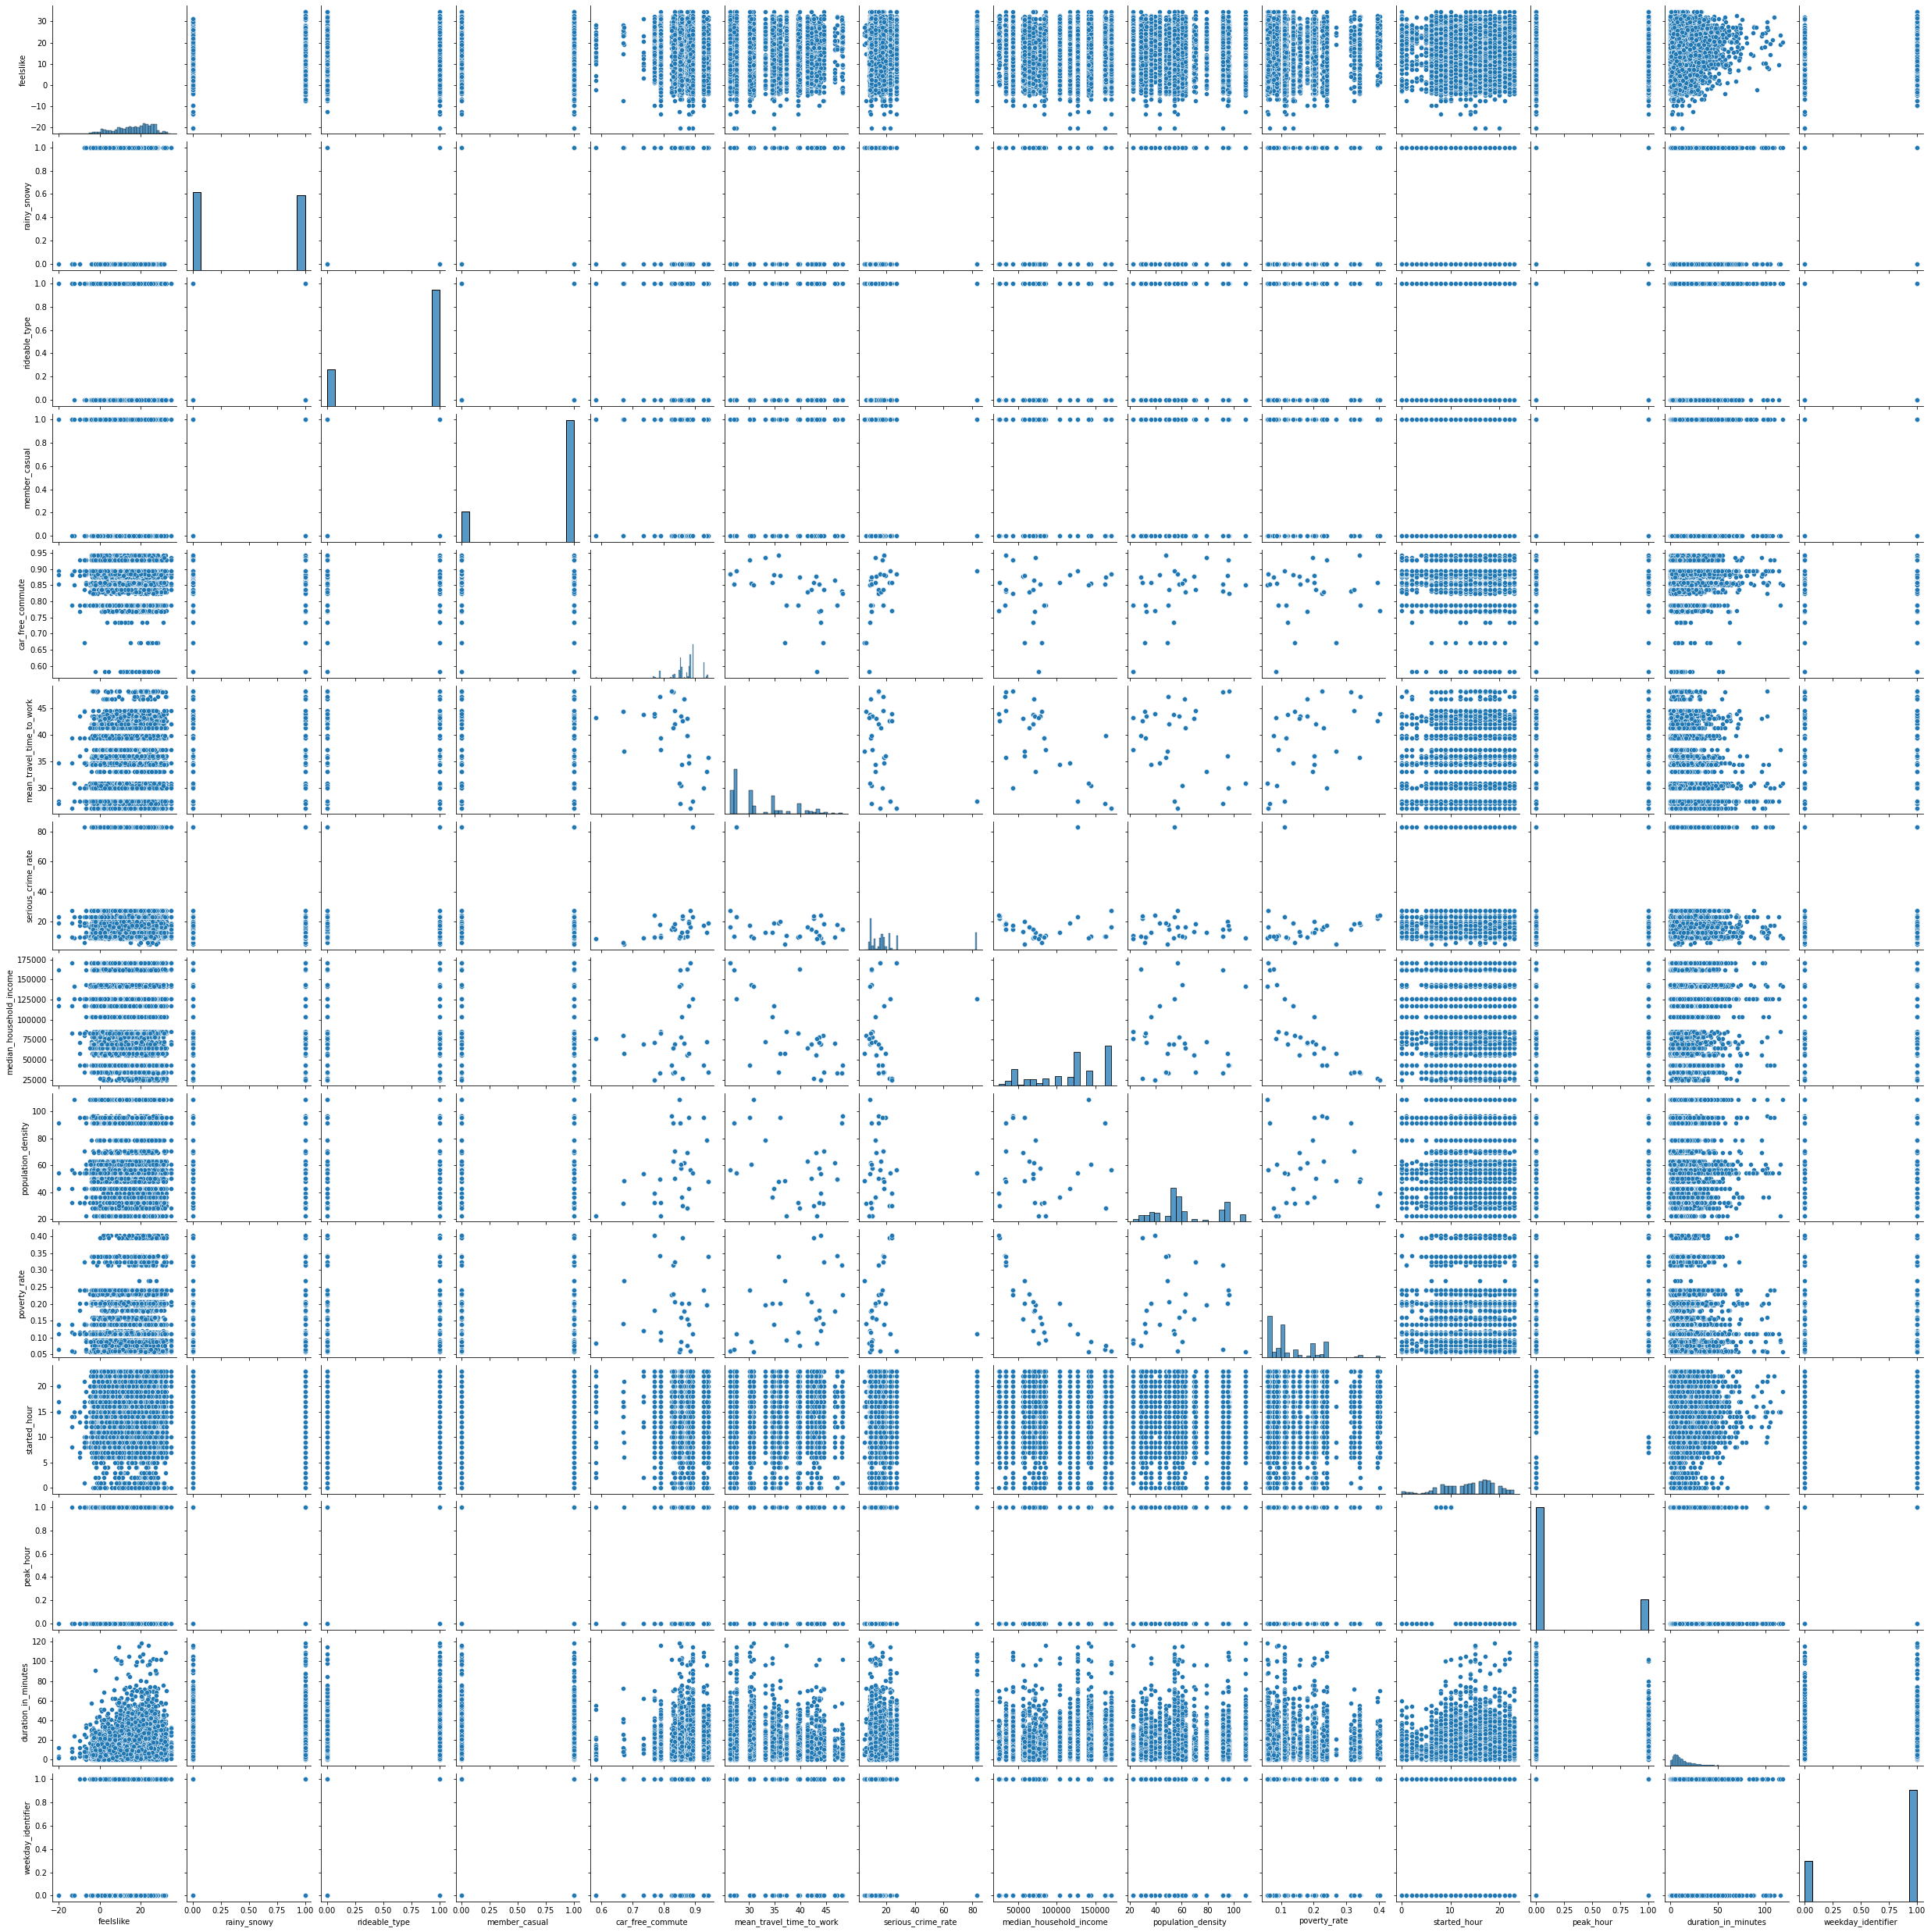

In [90]:
sns.pairplot(data_viz)

**Analysis**: from the pair plot, it shows that there are class imbalance for `member_casual` and `rideable_type`. This is a bit concerning as these two variables will be used as our response variables for our classification model and might cause classification inaccuracy. We might consider to use upsample/downsample to resolve this issue. 

<AxesSubplot:>

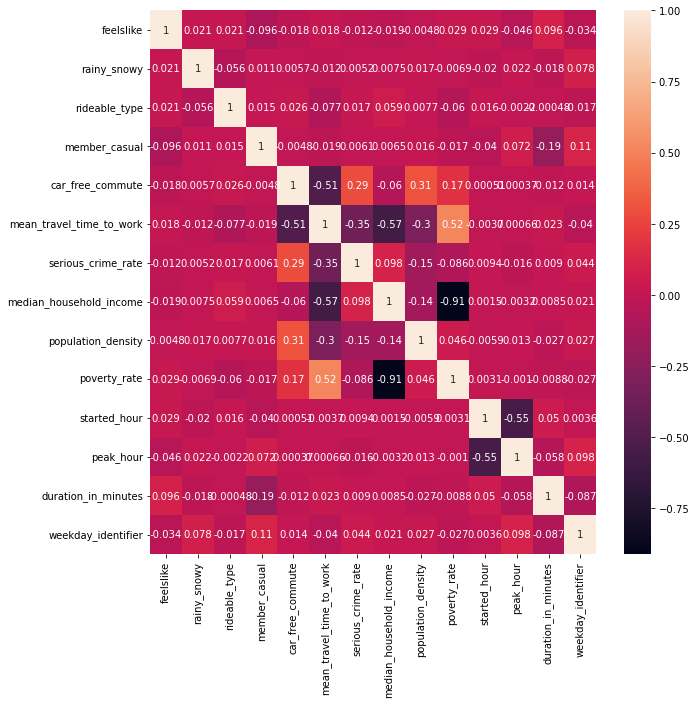

In [91]:
plt.figure(figsize = (10,10))
sns.heatmap(data_viz.corr(), annot=True)

**Analysis:** Based on the above correlation heat map, the bike data does not suffer co-variance issues as we anticipated previously. There are some co-variance between `poverty_rate` and `median_household_income`, and we might consider including one variable in our following analysis.

In [92]:
daily_use = raw_data_all.groupby('date')['ride_id'].count()
daily_use

date
2022-03-01    1450
2022-03-02    1671
2022-03-03    1399
2022-03-04    1211
2022-03-05    1241
              ... 
2023-02-24    1534
2023-02-25    1036
2023-02-26    1369
2023-02-27    1504
2023-02-28     953
Name: ride_id, Length: 365, dtype: int64

In [93]:
daily_use = pd.DataFrame(daily_use)
daily_use.head()


,ride_id
date,
2022-03-01,1450
2022-03-02,1671
2022-03-03,1399
2022-03-04,1211
2022-03-05,1241


In [94]:
daily_use_weather = pd.merge(daily_use, weatherdata, on = 'date')

In [95]:
daily_use_weather['raw_weekday'] = daily_use_weather['date'].apply(lambda x: x.weekday())
#trip_merged['weekday_identifier'] = trip_merged['raw_weekday'].apply(lambda x: 1 if x < 5 else 0)

In [96]:
daily_use_weather.head()

,date,ride_id,feelslike,rainy_snowy,raw_weekday
0,2022-03-01,1450,2.0,0.0,1
1,2022-03-02,1671,6.8,0.0,2
2,2022-03-03,1399,2.2,1.0,3
3,2022-03-04,1211,-4.1,0.0,4
4,2022-03-05,1241,2.3,0.0,5


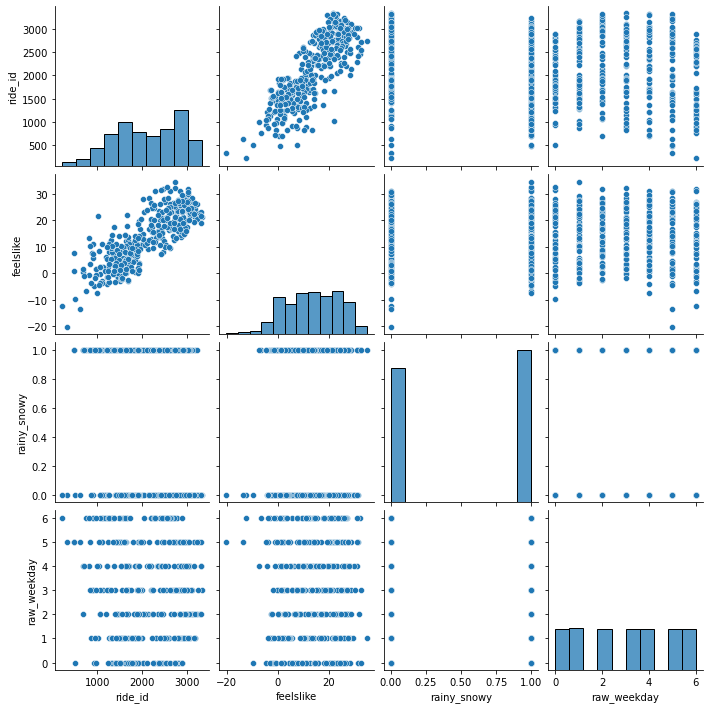

In [97]:
sns.pairplot(daily_use_weather)

**Analysis**: based on this pairplot, we observe that there is a strong correlation between "feelslike" temperature and number of trips. There is also differences in number of trips across different weekdays. 

# 3. Classification
In this section, we did two preliminary models to classify user type and bike type.

**Classification Variable 1: User Type** There are two types of users in the citi bike system. One is casual one-time users, the other are members.

**Classification Variable 2: Bike Type** There are two types of bikes available in the current citi bike system. One is classic bike / dockered bike(classic bike with dockers), the other is electric bike.

In [98]:
raw_data_all.columns

Index(['date', 'feelslike', 'rainy_snowy', 'ride_id', 'rideable_type',
       'start_station_name', 'end_station_name', 'member_casual', 'boro', 'CD',
       'car_free_commute', 'mean_travel_time_to_work', 'serious_crime_rate',
       'median_household_income', 'population_density', 'poverty_rate',
       'started_hour', 'peak_hour', 'duration_in_minutes',
       'weekday_identifier'],
      dtype='object')

In [113]:
cls_data = raw_data_all.drop(columns = ['date','ride_id','start_station_name','end_station_name','boro','CD'])

In [114]:
cls_data

,feelslike,rainy_snowy,rideable_type,member_casual,car_free_commute,mean_travel_time_to_work,serious_crime_rate,median_household_income,population_density,poverty_rate,started_hour,peak_hour,duration_in_minutes,weekday_identifier
0,2.0,0.0,0,1,0.885,26.3,27.4,170330.0,56.9,0.061,7,1,11.600000,1
1,2.0,0.0,1,1,0.885,26.3,27.4,170330.0,56.9,0.061,20,0,5.600000,1
2,2.0,0.0,1,1,0.885,26.3,27.4,170330.0,56.9,0.061,17,0,8.916667,1
3,2.0,0.0,0,1,0.885,26.3,27.4,170330.0,56.9,0.061,18,0,9.983333,1
4,2.0,0.0,0,1,0.936,33.1,12.4,71850.0,78.8,0.196,19,0,13.916667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775057,-1.7,1.0,1,1,0.582,43.2,8.3,76480.0,22.6,0.084,14,0,1.700000,1
775058,-1.7,1.0,1,1,0.864,46.7,9.3,70090.0,62.2,0.179,15,0,4.050000,1
775059,-1.7,1.0,1,1,0.854,43.6,10.2,78210.0,57.8,0.159,19,0,5.316667,1
775060,-1.7,1.0,1,1,0.874,39.9,9.9,163140.0,28.5,0.076,15,0,7.650000,1


In [115]:
ss = StandardScaler()
cls_data[["feelslike","car_free_commute","mean_travel_time_to_work","serious_crime_rate","median_household_income","population_density",
   "poverty_rate", "duration_in_minutes"]] = ss.fit_transform(cls_data[["feelslike","car_free_commute","mean_travel_time_to_work",
   "serious_crime_rate","median_household_income","population_density","poverty_rate","duration_in_minutes"]])
cls_data.head()

,feelslike,rainy_snowy,rideable_type,member_casual,car_free_commute,mean_travel_time_to_work,serious_crime_rate,median_household_income,population_density,poverty_rate,started_hour,peak_hour,duration_in_minutes,weekday_identifier
0,-1.551937,0.0,0,1,0.271322,-0.971337,0.166807,1.238346,-0.213590,-0.958227,7,1,-0.134490,1
1,-1.551937,0.0,1,1,0.271322,-0.971337,0.166807,1.238346,-0.213590,-0.958227,20,0,-0.614289,1
2,-1.551937,0.0,1,1,0.271322,-0.971337,0.166807,1.238346,-0.213590,-0.958227,17,0,-0.349067,1
3,-1.551937,0.0,0,1,0.271322,-0.971337,0.166807,1.238346,-0.213590,-0.958227,18,0,-0.263769,1
4,-1.551937,0.0,0,1,1.544909,0.248410,-0.522590,-0.970474,0.749673,0.779356,19,0,0.050766,1


In [116]:
X_cls_member = cls_data.drop(columns = ['member_casual'])
y_cls_member = cls_data.member_casual

In [117]:
X_cls_member_train, X_cls_member_test, y_cls_member_train, y_cls_member_test = train_test_split(X_cls_member, y_cls_member, test_size = 0.2, random_state = 1)

In [118]:
y_cls_member_train.value_counts()

1    490702
0    126706
Name: member_casual, dtype: int64

In [119]:
up_random = RandomOverSampler()
X_cls_member_train_up, y_cls_member_train_up = up_random.fit_resample(X_cls_member_train, y_cls_member_train)

In [120]:
lr = LogisticRegression(max_iter = 100000)
#parameters = {
#    'solver'  : ['lbfgs', 'liblinear','newton-cg','sag','saga'],
#}
#tuning = GridSearchCV(lr,                    # model
#                      param_grid = parameters,   # hyperparameters
#                      scoring='f1',        # metric for scoring
#                      cv=10)    
#tuning.fit()
lr.fit(X_cls_member_train_up, y_cls_member_train_up)
#pd.DataFrame(tuning.cv_results_)
#results = pd.concat([pd.DataFrame(tuning.cv_results_["params"]),pd.DataFrame(tuning.cv_results_["mean_test_score"], columns=["f1"])],axis=1)
#results


LogisticRegression(max_iter=100000)

In [121]:
y_cls_member_pred = lr.predict(X_cls_member_test)
print(classification_report(y_cls_member_test, y_cls_member_pred, target_names = ['Casual','Member']))

              precision    recall  f1-score   support

      Casual       0.32      0.58      0.41     31532
      Member       0.86      0.68      0.76    122821

    accuracy                           0.66    154353
   macro avg       0.59      0.63      0.59    154353
weighted avg       0.75      0.66      0.69    154353



Preliminary test for the second classifier: bike type

In [122]:
X_cls_bike = cls_data.drop(columns = ['rideable_type'])
y_cls_bike = cls_data.rideable_type

In [123]:
X_cls_bike_train, X_cls_bike_test, y_cls_bike_train, y_cls_bike_test = train_test_split(X_cls_bike, y_cls_bike, test_size = 0.2, random_state = 1)

In [124]:
y_cls_bike_train.value_counts()

1    470261
0    147147
Name: rideable_type, dtype: int64

In [125]:
up_random = RandomOverSampler()
X_cls_bike_train_up, y_cls_bike_train_up = up_random.fit_resample(X_cls_bike_train, y_cls_bike_train)

In [126]:
lr_bike = LogisticRegression(max_iter = 100000)
#parameters = {
#    'solver'  : ['lbfgs', 'liblinear','newton-cg','sag','saga'],
#}
#tuning = GridSearchCV(lr,                    # model
#                      param_grid = parameters,   # hyperparameters
#                      scoring='f1',        # metric for scoring
#                      cv=10)    
#tuning.fit()
lr_bike.fit(X_cls_bike_train_up, y_cls_bike_train_up)
#pd.DataFrame(tuning.cv_results_)
#results = pd.concat([pd.DataFrame(tuning.cv_results_["params"]),pd.DataFrame(tuning.cv_results_["mean_test_score"], columns=["f1"])],axis=1)
#results


LogisticRegression(max_iter=100000)

In [127]:
y_cls_bike_pred = lr_bike.predict(X_cls_bike_test)
print(classification_report(y_cls_bike_test, y_cls_bike_pred, target_names = ['Electric','Classic']))

              precision    recall  f1-score   support

    Electric       0.27      0.51      0.35     36790
     Classic       0.79      0.58      0.67    117563

    accuracy                           0.56    154353
   macro avg       0.53      0.54      0.51    154353
weighted avg       0.67      0.56      0.59    154353



# 4. Regression
**Prediction Variable: Number of total trips per day** We did a preliminary model on number of total trips per day. We may include some of the most popular stations and predict their daily usage in the next steps.


In [128]:
daily_use_weather['weekday_identifier'] = daily_use_weather['raw_weekday'].apply(lambda x: 1 if x < 5 else 0)
reg_data = daily_use_weather.drop(columns = 'raw_weekday')
reg_data.head()

,date,ride_id,feelslike,rainy_snowy,weekday_identifier
0,2022-03-01,1450,2.0,0.0,1
1,2022-03-02,1671,6.8,0.0,1
2,2022-03-03,1399,2.2,1.0,1
3,2022-03-04,1211,-4.1,0.0,1
4,2022-03-05,1241,2.3,0.0,0


In [129]:
X_reg = reg_data.drop(columns = ['ride_id', 'date'])
y_reg = reg_data.ride_id

In [130]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size = 0.2, random_state = 1)

In [131]:
linear_reg = LinearRegression()
linear_reg.fit(X_reg_train, y_reg_train)

LinearRegression()

In [132]:
print("CV error (linear regression): ", 
      np.abs(np.mean(cross_val_score(linear_reg, X_reg, y_reg,cv=10,scoring = 'neg_mean_squared_error'))))

CV error (linear regression):  146068.81980516904


In [133]:
linear_reg.score(X_reg_train, y_reg_train)

0.7532756721634516

R^2 in the train set is 0.75.

In [134]:
linear_reg.score(X_reg_test, y_reg_test)

0.7204976081105132

R^2 in the test set is 0.72.

## Reference
* https://automating-gis-processes.github.io/2016/Lesson3-point-in-polygon.html
* https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
* https://matplotlib.org/stable/gallery/color/named_colors.html
* https://geopandas.org/en/stable/docs/user_guide/mapping.html
* https://furmancenter.org/neighborhoods/view/greenpoint-williamsburg
* https://citibikenyc.com/system-data
* https://www.visualcrossing.com/weather/weather-data-services/New%20York%20City,USA/metric